This notebook replicates the code for Lesson 1 of QF607

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Computational Cost](#p1)

# [2. Fixed point representation](#p2)

# [3. Floating point representation](#p3)

# [4. Rounding error and machine epsilon](#p4)

# [5. Finite Difference](#p5)

In [20]:
import timeit
import math
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

# <a id = "p1">1.</a>  <font color = "green"> Computational Cost </font>  [back to table of contents](#top)

In [21]:
def opTiming(op, opName, repeat):
    elapsed_time = timeit.timeit(op, setup='import math', number=repeat)
    print(opName, "\t", elapsed_time / repeat)

In [22]:
repeat = int(1e8)

In [23]:
opTiming("x = 5.0 + 7.0", "add", repeat)
opTiming("x = 5.0 * 7.0", "mul", repeat)
opTiming("x = 5.0 / 7.0", "div", repeat)
opTiming("x = math.log(7.0)", "log", repeat)
opTiming("x = math.exp(7.0)", "exp", repeat)
opTiming("x = math.sqrt(7.0)", "sqrt", repeat)

add 	 5.9363866600324396e-09
mul 	 5.460752910003066e-09
div 	 5.464241250010673e-09
log 	 6.357436708996828e-08
exp 	 3.968664583000645e-08
sqrt 	 3.7375122500016004e-08


In [24]:
m1 = """
S = 100;K = 105;vol = 0.1;t=2;mu=0.01
d1 = (math.log(S * math.exp(mu*t) / K) + vol * vol * t / 2) / vol / math.sqrt(t)
"""

m2 = """
S = 100;K = 105;vol = 0.1;t=2;mu=0.01
stdev = vol * math.sqrt(t)
d1 = (math.log(S / K) + mu*t) / stdev + stdev / 2
"""

In [25]:
repeat = int(1e7)
opTiming(m1, 'm1', repeat)
opTiming(m2, 'm2', repeat)

m1 	 2.9701525419950483e-07
m2 	 2.0888969170046038e-07


# <a id = "p2">2.</a>  <font color = "green"> Fixed point representation </font>  [back to table of contents](#top)

In [26]:
# This function converts a floating-point number x into a fixed-point binary representation.
# x is the floating-point number to convert.
# w is the total number of bits in the fixed-point representation.
# b is the number of fractional bits (the precision).


def toFixedPoint(x : float, w : int, b : int) -> [int]:
    # set a[w-1] to 1 if x < 0, otherwise set a[w-1] to 0
    # Creates a list a of size w filled with zeros.
    # This list will hold the binary digits (bits) of the fixed-point representation.
    a = [0 for i in range(w)]
    # If x is negative, set the most significant bit (a[0]) to 1 (sign bit for two's complement representation).
    # Adjust x by adding 2**(w−1−b), which effectively handles the negative offset in fixed-point binary representation.
    if x < 0:
        a[0] = 1
        x += 2**(w-1-b)
    # The loop starts from bit 1 (the next most significant bit after the sign bit) and goes to the least significant bit.
    # For each bit position i, calculate y, which represents the scaled value of x divided by the weight of the current bit. The weight of each bit is determined by 
    # 2**(w−1−i−b), corresponding to the fixed-point scaling.
    for i in range(1, w):
        y = x / (2**(w-1-i-b))
        # Round down y to an integer (0 or 1) and store it in the ith position of a. This determines whether the current bit is set or not.
        a[i] = int(y)  # round y down to integer
        # Subtract the value represented by the current bit from x. This step reduces x for the next iteration to determine subsequent bits.
        x -= a[i] * (2**(w-1-i-b))
    # Once all the bits are determined, the function returns the list a, which is the binary fixed-point representation of the input x.
    return a

In [27]:
print(toFixedPoint(-10, 8, 1))
print(toFixedPoint(-9.5, 8, 1))
print(toFixedPoint(9.25, 8, 2))

[1, 1, 1, 0, 1, 1, 0, 0]
[1, 1, 1, 0, 1, 1, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 1]


In [28]:
print(toFixedPoint(20, 8, 3))
print(toFixedPoint(20, 9, 3))

[0, 2, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0]


In [29]:
# This function converts a floating-point number x into a fixed-point binary representation.
# x is the floating-point number to convert.
# w is the total number of bits in the fixed-point representation.
# b is the number of fractional bits (the precision).

def toFixedPoint2(x : float, w : int, b : int) -> [int]:
    # set a[w-1] to 1 if x < 0, otherwise set a[w-1] to 0
    # Creates a list a of size w filled with zeros.
    # This list will hold the binary digits (bits) of the fixed-point representation.
    a = [0 for i in range(w)]
    # If x is negative, set the most significant bit (a[0]) to 1 (sign bit for two's complement representation).
    # Adjust x by adding 2**(w−1−b), which effectively handles the negative offset in fixed-point binary representation.
    if x < 0:
        a[0] = 1
        x += 2**(w-1-b)
    # The loop starts from bit 1 (the next most significant bit after the sign bit) and goes to the least significant bit.
    # For each bit position i, calculate y, which represents the scaled value of x divided by the weight of the current bit. The weight of each bit is determined by 
    # 2**(w−1−i−b), corresponding to the fixed-point scaling.
    for i in range(1, w):
        y = x / (2**(w-1-i-b))
        # Checks if int(y) exceeds 1.
        # If it does, the value x cannot be represented within the fixed-point format defined by w and b.
        # If overflow occurs, an exception is raised with a descriptive error message indicating the issue.
        if int(y) > 1:
            raise OverflowError('fixed<' + str(w) + "," + str(b) + "> is not sufficient to represent " + str(x))
        # Convert y to an integer (0 or 1) and store it in the ith position of the list a.
        a[i] = int(y) # % 2  # round y down to integer
        # Subtract the value represented by the current bit from x.
        # This prepares x for calculating the next bit in subsequent iterations.
        x -= a[i] * (2**(w-1-i-b))
    # After processing all bits, return the list a containing the fixed-point binary representation of x.
    return a

In [30]:
print(toFixedPoint2(20, 8, 3))

OverflowError: fixed<8,3> is not sufficient to represent 20

# <a id = "p3">3.</a>  <font color = "green"> Floating point representation </font>  [back to table of contents](#top)

In [31]:
for f in (np.float32, np.float64, float):
    finfo = np.finfo(f)
    print(finfo.dtype, "\t exponent bits = ", finfo.nexp, "\t significand bits = ", finfo.nmant)

float32 	 exponent bits =  8 	 significand bits =  23
float64 	 exponent bits =  11 	 significand bits =  52
float64 	 exponent bits =  11 	 significand bits =  52


# <a id = "p4">4.</a>  <font color = "green"> Rounding error and machine epsilon </font>  [back to table of contents](#top)

In [32]:
x = 10776321
nsteps = 1200
s = x / nsteps
y = 0
for i in range(nsteps):
    y += s
print(x - y)

-7.82310962677002e-08


In [33]:
x = 10.56
print(x == x + 5e-16)

True


In [34]:
x = 0.1234567891234567890
y = 0.1234567891
scale = 1e16
z1 = (x-y) * scale
print("z1 = ", z1)

z1 =  234567.781864925


In [35]:
z2 = (x*scale - y*scale)
print("z2 = ", z2)

z2 =  234567.75


# <a id = "p5">5.</a>  <font color = "green"> Finite Difference </font>  [back to table of contents](#top)

![Finite Difference Formula](Finite_Difference_Formula.png)

In [36]:
# The function evaluates and plots the error of the finite difference approximation as the step size h decreases.

def testfinDiff():
    # Defines x0 as the point at which the derivative of the exponential function will be approximated.
    x0 = 0.1
    # Calculates the exact derivative of ex at x0 (which is ex0), and stores it in deriv.
    deriv = math.exp(x0)
    # Sets the initial step size h to 1.
    # Defines n, the number of iterations, as 60 (the number of halving steps for h).
    h = 1
    n = 60
    # Creates a list hs of length n, initially filled with the value h. This will store the step sizes at each iteration.
    hs = [h] * n
    # Creates a list err of length n, initialized to 0. This will store the errors for each step size.
    err = [0] * n
    # Begins a loop over n iterations to compute the finite difference approximation and the corresponding error.
    for i in range(0, n):
        # Approximates the derivative using the finite difference formula
        finDiff = (math.exp(x0+h) - math.exp(x0)) / h
        # Records the current value of h in the hs list at index i.
        hs[i] = h
        # Halve Step Size
        h = h/2
        #print(h)
        # Calculates the absolute error between the finite difference approximation (finDiff) and the exact derivative (deriv).
        err[i] = abs(finDiff - deriv)
        #print(err[i])
    # Plots err (error values) against hs (step sizes) on a graph.
    plt.plot(hs, err, label="error")
    # Configures both the x-axis (step sizes) and y-axis (errors) to use a logarithmic scale.
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

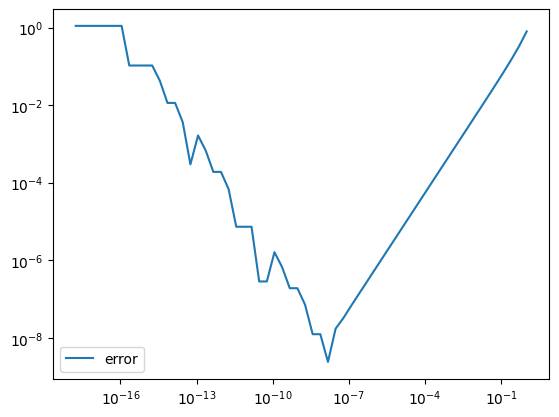

In [37]:
testfinDiff()